In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


In [178]:

def initial(imbDF):
    columns = list(imbDF.columns)
    
    #print(columns[1:-4])
    
   # Usablecolumns = columns[1:-4]
    #imbDF = imbDF[Usablecolumns]
    
    
    
    bs = list()
    
    for s in imbDF["Side"]:
        if s == 1:
            i = "Buy"
        else:
            i = "Sell"
        bs.append(i)    
    imbDF["B/S"] = bs
    
    f = list()
    for s in imbDF["FlipOn"]:
        if s == 1:
             i = "FLIP"
        else:
            i = "Same"
        f.append(i)    
    imbDF["Flip"] = f
    
    imbDF["Imbalance Value"] = imbDF["Imbalance"] * imbDF["Side"]
    
    
    
    columns = list(imbDF.columns)
    
    imbDF.drop_duplicates(inplace = True, keep='first')
    
    
    return imbDF


def ret(dataframe):
    dataframe = dataframe.copy()
    dataframe["Returns"] = 0.0
    dataframe["Next_Return"] = 0.0
    dataframe["EndOfDay_Return"] = 0.0
    dataframe["Pct_of_10DayMax_Imb"] = None
    dataframe["ZScore_10DayImb"] = None

    dataframe["Date"] = pd.to_datetime(dataframe["Date"])

    for d in sorted(dataframe["Date"].unique()):
        sdf = dataframe[dataframe["Date"] == d].copy().sort_values(by="SaleTime")

        # --- Returns ---
        returns = [0.0]
        for i in range(1, len(sdf)):
            prev = sdf.iloc[i - 1]["LastSale"]
            curr = sdf.iloc[i]["LastSale"]
            returns.append(-1 * ((curr - prev) / prev) * 100)
        sdf["Returns"] = returns
        sdf["Next_Return"] = sdf["Returns"].shift(-1).fillna(0)
        eod_price = sdf.iloc[-1]["LastSale"]
        sdf["EndOfDay_Return"] = -1 * ((eod_price - sdf["LastSale"]) / sdf["LastSale"]) * 100

        # --- Imbalance Context (Buy/Sell separated) ---
        window_start = d - pd.Timedelta(days=10)
        lookback = dataframe[(dataframe["Date"] < d) & (dataframe["Date"] >= window_start)]

        # Separate historical Buy and Sell
        lookback_buy = lookback[lookback["B/S"] == "Buy"]
        lookback_sell = lookback[lookback["B/S"] == "Sell"]

        def get_pct_z(row):
            val = row["Imbalance Value"]
            side = row["B/S"]

            if side == "Buy" and not lookback_buy.empty:
                max_imb = lookback_buy["Imbalance Value"].max()
                mean_imb = lookback_buy["Imbalance Value"].mean()
                std_imb = lookback_buy["Imbalance Value"].std()
                pct = (val / max_imb) * 100 if max_imb != 0 else 0
                z = (val - mean_imb) / std_imb if std_imb != 0 else 0
                return pct, z

            elif side == "Sell" and not lookback_sell.empty:
                max_imb = lookback_sell["Imbalance Value"].min()  # more negative
                mean_imb = lookback_sell["Imbalance Value"].mean()
                std_imb = lookback_sell["Imbalance Value"].std()
                pct = -1 * (val / max_imb) * 100 if max_imb != 0 else 0  # stays negative
                z = -1 * (val - mean_imb) / std_imb if std_imb != 0 else 0
                return pct, z

            return None, None

        # Apply per row in current day
        pct_z = sdf.apply(get_pct_z, axis=1)
        sdf["Pct_of_10DayMax_Imb"] = [p for p, z in pct_z]
        sdf["ZScore_10DayImb"] = [z for p, z in pct_z]

        dataframe.loc[sdf.index, ["Returns", "Next_Return", "EndOfDay_Return",
                                  "Pct_of_10DayMax_Imb", "ZScore_10DayImb"]] = sdf[[
            "Returns", "Next_Return", "EndOfDay_Return",
            "Pct_of_10DayMax_Imb", "ZScore_10DayImb"
        ]]

    return dataframe


    

def sort(s ,imbDF ):
    #imbDF[imbDF["Symbol"] == s]
    
    sortedDF = imbDF[imbDF["Symbol"] == s].sort_values(by='SaleTime', ascending = True)
    sortedDF['SaleTime'] = pd.to_datetime(sortedDF['SaleTime'])


    
    sortedDF["Date"] = sortedDF["SaleTime"].dt.date
    sortedDF["Time"] = sortedDF["SaleTime"].dt.strftime("%I:%M %p")
    sortedDF["Hour"] = sortedDF["SaleTime"].dt.strftime("%I")
    sortedDF["Day"] = sortedDF["SaleTime"].dt.day_name()
    sortedDF.drop_duplicates(inplace = True, keep='first', subset = ["SaleTime"])
    sortedDF = ret(sortedDF)
    #sortedDf = sortedDF.sort_values(by='SaleTime', ascending = False)    
    #sortedDF = sortedDF.drop(["SaleTime", "Side", "FlipOn"], axis=1)
    return sortedDF
    




In [ ]:
def sortTime(priceData,start_date, end_date ):
    
    
    # Step 2: Filter the DataFrame
    filtered_priceData = priceData[(priceData['Datetime'] >= start_date) & (priceData['Datetime'] <= end_date)]
    
    # Step 3: (Optional) Sort it by datetime
    filtered_priceData = filtered_priceData.sort_values('Datetime').reset_index(drop=True)
    return filtered_priceData



def compute_pivot_range(df):
    df = df.copy()
   
    df.index = df["Datetime"]    
   #df['Date'] = df.index.date


    
   # Daily aggregates
    daily = df.groupby('Date').agg(
        High=('High', 'max'),
        Low=('Low', 'min'),
        Close = ('Close' , 'last')
    )
    #print(daily)
    
    # Pivot and differential
    daily['Pivot'] = (daily['High'] + daily['Low'] + daily['Close']) / 3
    daily['Diff'] = abs(daily['Pivot'] - ((daily['High'] + daily['Low']) / 2))

    # Calculate bands using previous day's Pivot and Diff
    daily['UpperBand'] = daily['Pivot'] + daily['Diff']
    daily['LowerBand'] = daily['Pivot'] - daily['Diff']

    # Shift for use on next day's intraday data
    daily[['Pivot', 'UpperBand', 'LowerBand']] = daily[['Pivot', 'UpperBand', 'LowerBand']].shift()

    # Merge back with intraday data
    df = df.merge(
        daily[['Pivot', 'UpperBand', 'LowerBand']],
        left_on='Date',
        right_index=True,
        how='left'
    )

    

    return df
def compute_open_range(df):
    df = df.copy()
   
    #df.index = pd.to_datetime(df.index)
    
   # df['Date'] = df.index.date


    
    # Daily aggregates
    daily = df.groupby('Date').agg(
        High=('High', 'first'),
        Low=('Low', 'first'),
    )
    #print(daily)
    # Pivot and differential
    daily['OP High'] = daily["High"]
    daily['OP Low'] = daily["Low"]

    


    # Merge back with intraday data
    df = df.merge(
        daily[['OP High', 'OP Low']],
        left_on='Date',
        right_index=True,
        how='left'
    )

    

    return df




def getDFready(imbData , ticker , startdate , enddate):
    imbData = imbData.copy()

    imbData.loc[:, 'SaleTime'] = pd.to_datetime(imbData['SaleTime'])
    imbData.loc[:, 'SaleTime_5min'] = imbData['SaleTime'].dt.round('5min')
    
    col = imbData.pop("Pct_of_10DayMax_Imb")
    
    imbData.insert(3, "Pct_of_10DayMax_Imb", col)
    imbData = imbData[imbData["Symbol"] == ticker]
    
    
    
    csvfile = str(ticker) + ".csv"
    df = pd.read_csv(csvfile)
    columns = [
    "Symbol", "Date", "Time", "Open", "High", "Low", "Close", "x1", "x2"
    ]
    
    # Save first row
    first_row = df.iloc[0]
    
    # Drop it from the top
    df = df.drop(index=0).reset_index(drop=True)
    
    # Set proper column names
    df.columns = columns
    
    # Optionally, append first row back if it's actual data
    # (convert first_row to match the new column names)
    first_row_df = pd.DataFrame([first_row.values], columns=columns)
    df = pd.concat([first_row_df, df], ignore_index=True)


    #priceData.drop(labels=["Unnamed: 9", "Unnamed: 10" , "Unnamed: 11"], inplace=True)[source]
    priceData = df.dropna(axis=1)
    priceData = priceData.rename(columns={'high': 'High'})
    
    
    
    priceData['Time'] = priceData['Time'].astype(str).str.zfill(4)
    priceData['Datetime'] = pd.to_datetime(priceData['Date'] + ' ' + priceData['Time'].str[:2] + ':' + priceData['Time'].str[2:])
    
    priceData['Time'] = priceData['Datetime'].dt.time
    priceData = sortTime(priceData , startdate , enddate)
    priceData['Datetime_5min'] = priceData['Datetime'].dt.round('5min')
    
    
    #print(priceData[['Date', 'Time', 'Datetime']].head())
    
    priceData 

    pD = priceData
    pD = compute_open_range(priceData)
    pD = compute_pivot_range(pD)
    
    #priceData = compute_open_range(priceData)

    merged_df = pd.merge(
    imbData,
    pD,
    left_on='SaleTime_5min',
    right_on='Datetime_5min',
    how='inner'  # or 'left'/'outer' depending on what you want
    )
    return merged_df 


    
        

In [634]:
imbData = pd.read_csv("CleanedimbalanceData.csv")
imbData

,Symbol,Imbalance,PairOff,LastSale,SaleTime,B/S,Flip,Imbalance Value,Date,Time,Hour,Day,Returns,Next_Return,EndOfDay_Return,Pct_of_10DayMax_Imb,ZScore_10DayImb,Usable Time
0,A,12000,17000,132.710,2024-01-03 14:04:00,Buy,Same,12000,2024-01-03,02:04 PM,2,Wednesday,0.000000,0.241127,0.881622,80.000000,-0.697512,14:04:00
1,A,13000,17000,132.390,2024-01-03 14:09:00,Buy,Same,13000,2024-01-03,02:09 PM,2,Wednesday,0.241127,0.049097,0.642042,86.666667,-0.183556,14:09:00
2,A,13000,16000,132.325,2024-01-03 14:14:00,Buy,Same,13000,2024-01-03,02:14 PM,2,Wednesday,0.049097,0.132250,0.593236,86.666667,-0.183556,14:14:00
3,A,12000,16000,132.150,2024-01-03 14:20:00,Buy,Same,12000,2024-01-03,02:20 PM,2,Wednesday,0.132250,-0.355656,0.461597,80.000000,-0.697512,14:20:00
4,A,13000,17000,132.620,2024-01-03 14:27:00,Buy,Same,13000,2024-01-03,02:27 PM,2,Wednesday,-0.355656,-0.218670,0.814357,86.666667,-0.183556,14:27:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259821,ZTS,68000,8000,176.790,2024-03-13 15:05:00,Buy,Same,68000,2024-03-13,03:05 PM,3,Wednesday,0.118644,-0.000000,-0.079190,174.358974,4.391970,15:05:00
259822,ZTS,11000,91000,176.790,2024-03-13 15:07:00,Buy,Same,11000,2024-03-13,03:07 PM,3,Wednesday,-0.000000,-0.347870,-0.079190,28.205128,-0.504315,15:07:00
259823,ZTS,11000,92000,177.405,2024-03-13 15:17:00,Buy,Same,11000,2024-03-13,03:17 PM,3,Wednesday,-0.347870,0.149376,0.267749,28.205128,-0.504315,15:17:00
259824,ZTS,16000,96000,177.140,2024-03-13 15:24:00,Buy,Same,16000,2024-03-13,03:24 PM,3,Wednesday,0.149376,0.118550,0.118550,41.025641,-0.074816,15:24:00


In [122]:
from datetime import time
def getImbalancePivotPNL(imbData,ticker , sigPercent, startdate, enddate): 
    merged_df = getDFready(imbData , ticker, startdate, enddate)
    merged_df
    
    pos = 1000
    start_time = time(14, 0)  # 2:00 PM
    end_time = time(16, 0)    # 4:00 PM
    
    between_2_and_4 = merged_df[
        merged_df['Datetime_5min'].dt.time.between(start_time, end_time)
    ]
    
    dailys = merged_df.groupby('Date_x').agg(
            High=('High', 'max'),
            Low=('Low', 'min'),
            Close = ('Close' , 'last')
        )
    dailys.index = pd.to_datetime(dailys.index).date
    
    #print(dailys)
    seen_dates = set()
    TotalPNL = 0
    correctTrades = 0
    totalTrades = 0
    
    for _, row in between_2_and_4.iterrows():
        PNL = 0 
        dt = row['Datetime']
        price = row['Close']
        i = row["Pct_of_10DayMax_Imb"]
        highP = row["UpperBand"]
        lowP = row["LowerBand"]
        date_key = dt.date()
        if dt.time() == start_time and date_key in seen_dates:
            continue  # skip duplicates
    
        seen_dates.add(date_key)
    
        
            
        close = dailys.loc[date_key, "Close"]
        #print(close)
    
        
        if price > highP and dt.time() == start_time and i > sigPercent:
            PNL = (((close - price) / price)  *  pos )
            totalTrades +=1

            #print("Bull at 2pm", dt.time() , price , highP , i , dt.date(), "PNL: $" , PNL)
            
    
            
        elif price < lowP and dt.time() == start_time and i < -sigPercent:
            PNL =  -1 * (((close - price) / price)  *  pos )
            totalTrades +=1

            #print("Bear at 2pm" , dt.time() , price , lowP , i , dt.date(),  "PNL: $" , PNL)
        TotalPNL += PNL
    
        if PNL > 0 :
            correctTrades += 1
        
    
    
    
    return TotalPNL , correctTrades , totalTrades 



In [192]:
getImbalancePivotPNL(imbData, "A" , 100 , "2024-01-01" , "2024-04-01" )

(15.1106142452124, 4, 4)

In [14]:
imbalanceData = pd.read_csv("CleanedimbalanceData.csv")
tickers = list(imbalanceData["Symbol"].unique())

print(tickers)
print(len(tickers))




['A', 'ABBV', 'ABT', 'ACN', 'ADM', 'AEE', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALL', 'ALLE', 'ALTM', 'AMCR', 'AME', 'AMP', 'AMT', 'ANET', 'AON', 'AOS', 'APD', 'APH', 'APTV', 'ARE', 'ASX', 'ATMU', 'ATO', 'AVB', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIO', 'BK', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BRSP', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CABO', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CE', 'CF', 'CFG', 'CHD', 'CI', 'CL', 'CLX', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHI', 'CNP', 'COF', 'COP', 'CPB', 'CPT', 'CRL', 'CRM', 'CTRA', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DOC', 'DOV', 'DOW', 'DPZ', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'ENB', 'EOG', 'EPAM', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'F', 'FCX', 'FDS', 'FDX', 'FE', 'FICO', 'FIS', 'FMC', 'FRT', 'FSLY', 'FTV',

In [22]:
tickersWithFiles = []
for tick in tickers:
    try:
        csvFIleName = str(tick) + ".csv"
        df = pd.read_csv(csvFIleName)
    except:
        continue
    else:
        tickersWithFiles.append(tick)
print(tickersWithFiles)
print(len(tickersWithFiles))

['A', 'ABBV', 'ABT', 'ACN', 'ADM', 'AEE', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALL', 'ALLE', 'ALTM', 'AMCR', 'AME', 'AMP', 'AMT', 'ANET', 'AON', 'AOS', 'APD', 'APH', 'APTV', 'ARE', 'ASX', 'ATMU', 'ATO', 'AVB', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIO', 'BK', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BRSP', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CABO', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CCL', 'CE', 'CF', 'CFG', 'CHD', 'CI', 'CL', 'CLX', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHI', 'CNP', 'COF', 'COP', 'CPB', 'CPT', 'CRL', 'CRM', 'CTRA', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DOC', 'DOV', 'DOW', 'DPZ', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'ENB', 'EOG', 'EPAM', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'F', 'FCX', 'FDS', 'FDX', 'FE', 'FICO', 'FIS', 'FMC', 'FRT', 'FSLY', 'FTV', 'GD', '

In [108]:
grandPNl = 0
PNLsList = []
grandCorrectTrades = 0 
grandTotalTrades = 0
for tick in tickersWithFiles:
    #print(tick)
    incP , incCT , incTT = getImbalancePivotPNL(imbData, tick , 120 , "2024-01-01" , "2024-04-01" )
    grandPNl += incP
    grandCorrectTrades += incCT
    grandTotalTrades += incTT
    PNLsList.append(incP)
percentCorrect = (grandCorrectTrades / grandTotalTrades) * 100
print("$" , grandPNl , percentCorrect , grandTotalTrades)





$ 173.48254690951268 51.11111111111111 405


In [182]:
#Jun2Aug2023Imbals 

imbalanceData2 = pd.read_csv("Jun2Aug2023Imbals.csv")
tickers2 = list(imbalanceData2["Symbol"].unique())
imbData2 =  initial(imbalanceData2)

all_sorted = []

for ticker in imbData2["Symbol"].unique(): 
    df_sorted = sort(ticker ,imbData2 ) 
    all_sorted.append(df_sorted)

combined_df = pd.concat(all_sorted, ignore_index=True)

combined_df = combined_df.sort_values(by=["Symbol", "SaleTime"]).reset_index(drop=True) 
combined_df = combined_df.drop(["Side", "FlipOn"], axis=1)

imbData2 = combined_df

print(tickers2)
print(len(tickers2))


['A', 'AAP', 'ABBV', 'ABC', 'ABR', 'ABT', 'ACI', 'ACN', 'ADC', 'ADM', 'AEE', 'AES', 'AFL', 'AGL', 'AI', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALLY', 'AMCR', 'AME', 'AMP', 'AMT', 'AMX', 'ANET', 'AON', 'AOS', 'APAM', 'APD', 'APH', 'APTV', 'ARE', 'ARMK', 'ARR', 'ATMU', 'ATO', 'ATUS', 'AVA', 'AVB', 'AVY', 'AWK', 'AXL', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BALL', 'BAM', 'BAX', 'BBD', 'BBWI', 'BBY', 'BCE', 'BDN', 'BDX', 'BE', 'BEKE', 'BEN', 'BERY', 'BG', 'BHVN', 'BIG', 'BIO', 'BK', 'BLK', 'BMO', 'BMY', 'BNS', 'BOH', 'BOX', 'BP', 'BR', 'BRK.B', 'BRO', 'BRX', 'BSX', 'BTE', 'BTU', 'BWA', 'BWXT', 'BX', 'BXMT', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CAVA', 'CB', 'CBRE', 'CCI', 'CCJ', 'CCK', 'CCL', 'CDAY', 'CE', 'CF', 'CFG', 'CHD', 'CHGG', 'CI', 'CIM', 'CL', 'CLF', 'CLVT', 'CLX', 'CM', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHI', 'CNP', 'CNQ', 'CNX', 'COF', 'COHR', 'COO', 'COP', 'COTY', 'CP', 'CPB', 'CPNG', 'CPT', 'CRC', 'CRL', 'CRM', 'CS', 'CSTM', 'CTLT', 'CTRA', 'CTRE', 'CTVA', 'CVN

In [120]:
tickersWithFiles2 = []
for tick in tickers2:
    try:
        csvFIleName = str(tick) + ".csv"
        df = pd.read_csv(csvFIleName)
    except:
        continue
    else:
        tickersWithFiles2.append(tick)
print(tickersWithFiles2)
print(len(tickersWithFiles2))

['A', 'AAP', 'ABBV', 'ABR', 'ABT', 'ACI', 'ACN', 'ADC', 'ADM', 'AEE', 'AES', 'AFL', 'AGL', 'AI', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALLY', 'AMCR', 'AME', 'AMP', 'AMT', 'AMX', 'ANET', 'AON', 'AOS', 'APAM', 'APD', 'APH', 'APTV', 'ARE', 'ARMK', 'ARR', 'ATMU', 'ATO', 'ATUS', 'AVA', 'AVB', 'AVY', 'AWK', 'AXL', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BALL', 'BAM', 'BAX', 'BBD', 'BBWI', 'BBY', 'BCE', 'BDN', 'BDX', 'BE', 'BEKE', 'BEN', 'BERY', 'BG', 'BHVN', 'BIG', 'BIO', 'BK', 'BLK', 'BMO', 'BMY', 'BNS', 'BOH', 'BOX', 'BP', 'BR', 'BRK.B', 'BRO', 'BRX', 'BSX', 'BTE', 'BTU', 'BWA', 'BWXT', 'BX', 'BXMT', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CAVA', 'CB', 'CBRE', 'CCI', 'CCJ', 'CCK', 'CCL', 'CE', 'CF', 'CFG', 'CHD', 'CHGG', 'CI', 'CIM', 'CL', 'CLF', 'CLVT', 'CLX', 'CM', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHI', 'CNP', 'CNQ', 'CNX', 'COF', 'COHR', 'COO', 'COP', 'COTY', 'CP', 'CPB', 'CPNG', 'CPT', 'CRC', 'CRL', 'CRM', 'CSTM', 'CTLT', 'CTRA', 'CTRE', 'CTVA', 'CVNA', 'CVS', 'CVX', 'D'

In [188]:
cleaned_df = imbData2.dropna()

imbData2 = cleaned_df

imbData2

,#id,Symbol,Imbalance,PairOff,LastSale,SaleTime,B/S,Flip,Imbalance Value,Date,Time,Hour,Day,Returns,Next_Return,EndOfDay_Return,Pct_of_10DayMax_Imb,ZScore_10DayImb
23,1354379,A,7000,69000,118.090,2023-06-02 15:27:00,Sell,FLIP,-7000,2023-06-02,03:27 PM,03,Friday,-0.152659,0.016936,-0.084681,-50.0,-0.585825
27,1355644,A,8000,8000,117.305,2023-06-05 14:04:00,Buy,Same,8000,2023-06-05,02:04 PM,02,Monday,0.000000,-0.055411,-0.520012,22.222222,-1.805309
28,1355990,A,10000,8000,117.370,2023-06-05 14:10:00,Buy,Same,10000,2023-06-05,02:10 PM,02,Monday,-0.055411,-0.460083,-0.464344,27.777778,-1.563594
29,1357105,A,11000,9000,117.910,2023-06-05 14:31:00,Buy,Same,11000,2023-06-05,02:31 PM,02,Monday,-0.460083,0.220507,-0.004241,30.555556,-1.442736
30,1357570,A,13000,10000,117.650,2023-06-05 14:40:00,Buy,Same,13000,2023-06-05,02:40 PM,02,Monday,0.220507,-0.063748,-0.225244,36.111111,-1.201021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365044,1728891,ZTS,220000,150000,191.850,2023-08-31 15:19:00,Sell,Same,-220000,2023-08-31,03:19 PM,03,Thursday,0.093735,0.156372,0.200678,-666.666667,28.270995
365045,1729162,ZTS,200000,171000,191.550,2023-08-31 15:25:00,Sell,Same,-200000,2023-08-31,03:25 PM,03,Thursday,0.156372,0.062647,0.044375,-606.060606,25.549152
365046,1729531,ZTS,213000,163000,191.430,2023-08-31 15:33:00,Sell,Same,-213000,2023-08-31,03:33 PM,03,Thursday,0.062647,0.094029,-0.018283,-645.454545,27.31835
365047,1729871,ZTS,197000,185000,191.250,2023-08-31 15:39:00,Sell,Same,-197000,2023-08-31,03:39 PM,03,Thursday,0.094029,-0.112418,-0.112418,-596.969697,25.140875


In [204]:
grandPNl = 0
PNLsList = []
grandCorrectTrades = 0 
grandTotalTrades = 0
for tick in tickersWithFiles2:
    #print(tick)
    incP , incCT , incTT = getImbalancePivotPNL(imbData2, tick , 120 , "2023-06-02" , "2023-08-31" )
    grandPNl += incP
    grandCorrectTrades += incCT
    grandTotalTrades += incTT
    PNLsList.append(incP)
percentCorrect = (grandCorrectTrades / grandTotalTrades) * 100
print("$" , grandPNl , percentCorrect , grandTotalTrades)

$ 360.9295178479996 59.082568807339456 545


In [214]:
#Sep2Dec2023Imbals

imbalanceData3 = pd.read_csv("Sep2Dec2023Imbals.csv")
tickers3 = list(imbalanceData3["Symbol"].unique())
imbData3 =  initial(imbalanceData3)

all_sorted2 = []

for ticker in imbData3["Symbol"].unique(): 
    df_sorted2 = sort(ticker ,imbData3 ) 
    all_sorted2.append(df_sorted2)

combined_df3 = pd.concat(all_sorted2, ignore_index=True)

combined_df3 = combined_df3.sort_values(by=["Symbol", "SaleTime"]).reset_index(drop=True) 
combined_df3 = combined_df3.drop(["Side", "FlipOn"], axis=1)

imbData3 = combined_df3

print(tickers3)
print(len(tickers3))


['A', 'AA', 'AAN', 'ABBV', 'ABEV', 'ABR', 'ABT', 'ACI', 'ACN', 'ADM', 'ADP', 'AEE', 'AEM', 'AEO', 'AES', 'AFL', 'AGL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALIT', 'ALK', 'ALL', 'ALLE', 'ALLY', 'AM', 'AMBP', 'AMCR', 'AMD', 'AME', 'AMH', 'AMP', 'AMPS', 'AMR', 'AMT', 'ANET', 'ANF', 'AON', 'AOS', 'APD', 'APH', 'APTV', 'ARE', 'ASX', 'ATO', 'ATUS', 'AVB', 'AVD', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BANC', 'BAX', 'BBD', 'BBWI', 'BBY', 'BDX', 'BE', 'BEKE', 'BEN', 'BF.B', 'BG', 'BIO', 'BIPC', 'BIRK', 'BK', 'BKI', 'BLDR', 'BLK', 'BMO', 'BMY', 'BN', 'BNS', 'BOOT', 'BP', 'BR', 'BRK.B', 'BRO', 'BSX', 'BTU', 'BURL', 'BVN', 'BVS', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CCJ', 'CCL', 'CDAY', 'CE', 'CEQP', 'CF', 'CFG', 'CHD', 'CHPT', 'CHWY', 'CI', 'CIVI', 'CL', 'CLF', 'CLVT', 'CLX', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHA', 'CNHI', 'CNM', 'CNP', 'CNQ', 'COF', 'COO', 'COP', 'COTY', 'CPB', 'CPNG', 'CPT', 'CRBG', 'CRH', 'CRL', 'CRM', 'CTLT', 'CTRA', 'CTRE', 'CTVA'

In [216]:
tickersWithFiles3 = []
for tick in tickers3:
    try:
        csvFIleName = str(tick) + ".csv"
        df = pd.read_csv(csvFIleName)
    except:
        continue
    else:
        tickersWithFiles3.append(tick)
print(tickersWithFiles3)
print(len(tickersWithFiles3))

['A', 'AA', 'AAN', 'ABBV', 'ABEV', 'ABR', 'ABT', 'ACI', 'ACN', 'ADM', 'ADP', 'AEE', 'AEM', 'AEO', 'AES', 'AFL', 'AGL', 'AIG', 'AIZ', 'AJG', 'ALB', 'ALIT', 'ALK', 'ALL', 'ALLE', 'ALLY', 'AM', 'AMBP', 'AMCR', 'AMD', 'AME', 'AMH', 'AMP', 'AMPS', 'AMR', 'AMT', 'ANET', 'ANF', 'AON', 'AOS', 'APD', 'APH', 'APTV', 'ARE', 'ASX', 'ATO', 'ATUS', 'AVB', 'AVD', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BABA', 'BAC', 'BANC', 'BAX', 'BBD', 'BBWI', 'BBY', 'BDX', 'BE', 'BEKE', 'BEN', 'BF.B', 'BG', 'BIO', 'BIPC', 'BIRK', 'BK', 'BLDR', 'BLK', 'BMO', 'BMY', 'BN', 'BNS', 'BOOT', 'BP', 'BR', 'BRK.B', 'BRO', 'BSX', 'BTU', 'BURL', 'BVN', 'BVS', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CCJ', 'CCL', 'CE', 'CF', 'CFG', 'CHD', 'CHPT', 'CHWY', 'CI', 'CIVI', 'CL', 'CLF', 'CLVT', 'CLX', 'CMA', 'CMG', 'CMI', 'CMS', 'CNC', 'CNHI', 'CNM', 'CNP', 'CNQ', 'COF', 'COO', 'COP', 'COTY', 'CPB', 'CPNG', 'CPT', 'CRBG', 'CRH', 'CRL', 'CRM', 'CTLT', 'CTRA', 'CTRE', 'CTVA', 'CVE', 'CVS', 'CVX', 'CWAN', 

In [218]:
cleaned_df = imbData3.dropna()

imbData3 = cleaned_df

imbData3

,#id,Symbol,Imbalance,PairOff,LastSale,SaleTime,B/S,Flip,Imbalance Value,Date,Time,Hour,Day,Returns,Next_Return,EndOfDay_Return,Pct_of_10DayMax_Imb,ZScore_10DayImb
12,1735557,A,35000,186000,119.470,2023-09-05 14:08:00,Buy,Same,35000,2023-09-05,02:08 PM,02,Tuesday,0.000000,0.033481,0.175776,159.090909,2.914078
13,1736076,A,35000,186000,119.430,2023-09-05 14:17:00,Buy,Same,35000,2023-09-05,02:17 PM,02,Tuesday,0.033481,0.075358,0.142343,159.090909,2.914078
14,1736704,A,34000,188000,119.340,2023-09-05 14:29:00,Buy,Same,34000,2023-09-05,02:29 PM,02,Tuesday,0.075358,-0.079604,0.067035,154.545455,2.797514
15,1737039,A,36000,188000,119.435,2023-09-05 14:36:00,Buy,Same,36000,2023-09-05,02:36 PM,02,Tuesday,-0.079604,0.020932,0.146523,163.636364,3.030641
16,1737354,A,35000,188000,119.410,2023-09-05 14:42:00,Buy,Same,35000,2023-09-05,02:42 PM,02,Tuesday,0.020932,-0.033498,0.125618,159.090909,2.914078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466720,2223512,ZTS,83000,29000,197.655,2023-12-29 15:14:00,Buy,Same,83000,2023-12-29,03:14 PM,03,Friday,-0.035428,0.123953,-0.068301,49.112426,-0.014439
466721,2223962,ZTS,84000,29000,197.410,2023-12-29 15:21:00,Buy,Same,84000,2023-12-29,03:21 PM,03,Friday,0.123953,-0.129173,-0.192493,49.704142,-0.001504
466722,2224365,ZTS,101000,32000,197.665,2023-12-29 15:27:00,Buy,Same,101000,2023-12-29,03:27 PM,03,Friday,-0.129173,-0.025295,-0.063238,59.763314,0.218387
466723,2224730,ZTS,102000,31000,197.715,2023-12-29 15:33:00,Buy,Same,102000,2023-12-29,03:33 PM,03,Friday,-0.025295,-0.037933,-0.037933,60.35503,0.231321


In [223]:
grandPNl = 0
PNLsList = []
grandCorrectTrades = 0 
grandTotalTrades = 0
for tick in tickersWithFiles3:
    #print(tick)
    incP , incCT , incTT = getImbalancePivotPNL(imbData3, tick , 120 , "2023-09-05" , "2023-12-29" )
    grandPNl += incP
    grandCorrectTrades += incCT
    grandTotalTrades += incTT
    PNLsList.append(incP)
percentCorrect = (grandCorrectTrades / grandTotalTrades) * 100
print("$" , grandPNl , percentCorrect , grandTotalTrades)

$ 410.4009607405561 56.72609400324149 617


In [231]:
compList = [imbData3 , imbData2 , imbData]
imbDataComprehensive = pd.concat(compList)
imbDataComprehensive

,#id,Symbol,Imbalance,Pct_of_10DayMax_Imb,PairOff,LastSale,SaleTime,B/S,Flip,Imbalance Value,Date,Time,Hour,Day,Returns,Next_Return,EndOfDay_Return,ZScore_10DayImb,SaleTime_5min,Usable Time
12,1735557.0,A,35000,159.090909,186000,119.470,2023-09-05 14:08:00,Buy,Same,35000,2023-09-05 00:00:00,02:08 PM,02,Tuesday,0.000000,0.033481,0.175776,2.914078,2023-09-05 14:10:00,NaN
13,1736076.0,A,35000,159.090909,186000,119.430,2023-09-05 14:17:00,Buy,Same,35000,2023-09-05 00:00:00,02:17 PM,02,Tuesday,0.033481,0.075358,0.142343,2.914078,2023-09-05 14:15:00,NaN
14,1736704.0,A,34000,154.545455,188000,119.340,2023-09-05 14:29:00,Buy,Same,34000,2023-09-05 00:00:00,02:29 PM,02,Tuesday,0.075358,-0.079604,0.067035,2.797514,2023-09-05 14:30:00,NaN
15,1737039.0,A,36000,163.636364,188000,119.435,2023-09-05 14:36:00,Buy,Same,36000,2023-09-05 00:00:00,02:36 PM,02,Tuesday,-0.079604,0.020932,0.146523,3.030641,2023-09-05 14:35:00,NaN
16,1737354.0,A,35000,159.090909,188000,119.410,2023-09-05 14:42:00,Buy,Same,35000,2023-09-05 00:00:00,02:42 PM,02,Tuesday,0.020932,-0.033498,0.125618,2.914078,2023-09-05 14:40:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259821,NaN,ZTS,68000,174.358974,8000,176.790,2024-03-13 15:05:00,Buy,Same,68000,2024-03-13,03:05 PM,3,Wednesday,0.118644,-0.000000,-0.079190,4.39197,2024-03-13 15:05:00,15:05:00
259822,NaN,ZTS,11000,28.205128,91000,176.790,2024-03-13 15:07:00,Buy,Same,11000,2024-03-13,03:07 PM,3,Wednesday,-0.000000,-0.347870,-0.079190,-0.504315,2024-03-13 15:05:00,15:07:00
259823,NaN,ZTS,11000,28.205128,92000,177.405,2024-03-13 15:17:00,Buy,Same,11000,2024-03-13,03:17 PM,3,Wednesday,-0.347870,0.149376,0.267749,-0.504315,2024-03-13 15:15:00,15:17:00
259824,NaN,ZTS,16000,41.025641,96000,177.140,2024-03-13 15:24:00,Buy,Same,16000,2024-03-13,03:24 PM,3,Wednesday,0.149376,0.118550,0.118550,-0.074816,2024-03-13 15:25:00,15:24:00


In [1289]:
tickersComp = list(imbDataComprehensive["Symbol"].unique())
print(len(tickersComp))
tickersWithFilesComp = []
for tick in tickersComp:
    try:
        csvFIleName = str(tick) + ".csv"
        df = pd.read_csv(csvFIleName)
    except:
        continue
    else:
        tickersWithFilesComp.append(tick)
#print(tickersWithFilesComp)
print(len(tickersWithFilesComp))



454
373


In [248]:
grandPNl = 0
PNLsList = []
grandCorrectTrades = 0 
grandTotalTrades = 0
for tick in tickersWithFilesComp:
    #print(tick)
    incP , incCT , incTT = getImbalancePivotPNL(imbDataComprehensive, tick , 120 , "2023-06-02" , "2024-04-01" )
    grandPNl += incP
    grandCorrectTrades += incCT
    grandTotalTrades += incTT
    PNLsList.append(incP)
percentCorrect = (grandCorrectTrades / grandTotalTrades) * 100
print("$" , grandPNl , percentCorrect , grandTotalTrades)

$ 1084.3965340726972 56.72009864364982 1622


In [252]:
1622 / (20 * 9)

9.011111111111111

In [258]:
from datetime import time
def getImbalancePivotPNLDF(imbData,ticker , sigPercent, startdate, enddate): 
    merged_df = getDFready(imbData , ticker, startdate, enddate)
    merged_df
    
    pos = 1000
    start_time = time(14, 0)  # 2:00 PM
    end_time = time(16, 0)    # 4:00 PM
    
    between_2_and_4 = merged_df[
        merged_df['Datetime_5min'].dt.time.between(start_time, end_time)
    ]
    
    dailys = merged_df.groupby('Date_x').agg(
            High=('High', 'max'),
            Low=('Low', 'min'),
            Close = ('Close' , 'last')
        )
    dailys.index = pd.to_datetime(dailys.index).date
    
    #print(dailys)
    seen_dates = set()
    TotalPNL = 0
    correctTrades = 0
    totalTrades = 0

    dates = []
    symbols = []
    PNLs = []
    postype = []
    
    for _, row in between_2_and_4.iterrows():
        PNL = 0 
        dt = row['Datetime']
        price = row['Close']
        i = row["Pct_of_10DayMax_Imb"]
        highP = row["UpperBand"]
        lowP = row["LowerBand"]
        date_key = dt.date()
        if dt.time() == start_time and date_key in seen_dates:
            continue  # skip duplicates
    
        seen_dates.add(date_key)
    
        
            
        close = dailys.loc[date_key, "Close"]
        #print(close)
    
        
        if price > highP and dt.time() == start_time and i > sigPercent:
            PNL = (((close - price) / price)  *  pos )
            totalTrades +=1
            dates.append(dt.date())
            symbols.append(ticker)
            PNLs.append(PNL)
            postype.append("Long")
            

            #print("Bull at 2pm", dt.time() , price , highP , i , dt.date(), "PNL: $" , PNL)
            
    
            
        elif price < lowP and dt.time() == start_time and i < -sigPercent:
            PNL =  -1 * (((close - price) / price)  *  pos )
            totalTrades +=1

            dates.append(dt.date())
            symbols.append(ticker)
            PNLs.append(PNL)
            postype.append("Short")
            

            #print("Bear at 2pm" , dt.time() , price , lowP , i , dt.date(),  "PNL: $" , PNL)
        TotalPNL += PNL
    
        if PNL > 0 :
            correctTrades += 1
        
    
    dictPNL = {"Date": dates, "Symbol" : symbols ,"PNL" : PNLs , "L/S" : postype}
    dfPNL = pd.DataFrame(dictPNL)
    
    
    return dfPNL



In [260]:
#dictsPNL = {"Date": [], "Symbol" : [] ,"PNL" : [] , "L/S" : []}

PNLDataFrame = pd.DataFrame(dictsPNL)
dfList = []

for tick in tickersWithFilesComp:

    incDF = getImbalancePivotPNLDF(imbDataComprehensive, tick , 120 , "2023-06-02" , "2024-04-01" )
    dfList.append(incDF)
    

dictsPNL = pd.concat(dfList)

dictsPNL

,Date,Symbol,PNL,L/S
0,2023-09-11,A,5.821132,Short
1,2023-10-20,A,6.787330,Short
2,2023-11-15,A,-3.938041,Long
3,2023-06-06,A,0.510986,Short
4,2023-06-16,A,4.869192,Long
...,...,...,...,...
3,2023-08-14,SYK,-0.421053,Long
4,2024-01-22,SYK,0.255338,Long
0,2023-06-12,AAP,-3.455010,Short
1,2023-07-19,AAP,8.070127,Long


In [282]:
sortedPNL = dictsPNL.sort_values(by='Date')

sortedPNL["Culmulative PNL"] = sortedPNL['PNL'].cumsum()

sortedPNL

,Date,Symbol,PNL,L/S,Culmulative PNL
2,2023-06-02,MMM,-1.754386,Short,-1.754386
3,2023-06-02,AMT,4.901450,Short,3.147064
0,2023-06-02,PGR,-2.411513,Short,0.735551
6,2023-06-02,OMC,-2.190581,Short,-1.455030
2,2023-06-02,O,5.005840,Short,3.550810
...,...,...,...,...,...
3,2024-03-13,GD,0.109095,Long,1095.012565
6,2024-03-13,GIS,-2.267231,Long,1092.745334
7,2024-03-13,DHI,-12.219182,Long,1080.526153
12,2024-03-13,CCI,7.226086,Short,1087.752239


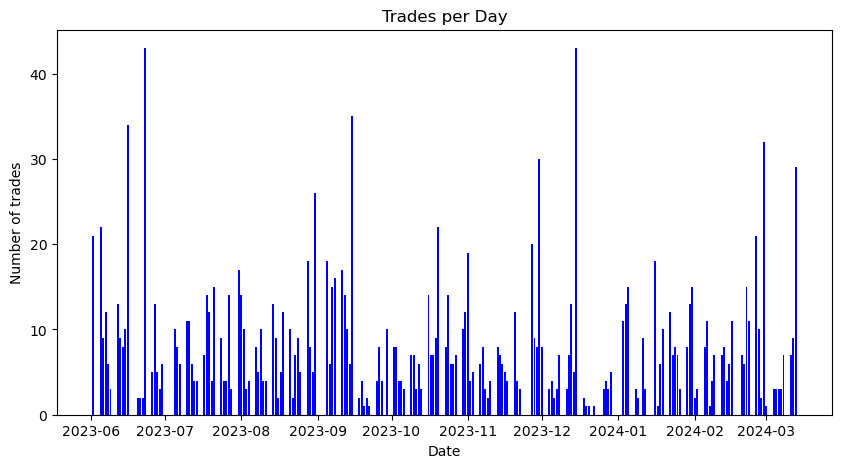

In [380]:
TradesPerDay = pd.DataFrame(sortedPNL.groupby("Date")["Symbol"].count())
TradesPerDay


fig , ax = plt.subplots(figsize = (10,5))
ax.bar(TradesPerDay.index , TradesPerDay["Symbol"], color = "blue")

ax.set(title = "Trades per Day", xlabel = "Date" , ylabel = "Number of trades")
plt.show()



In [352]:
PNLbyType = pd.DataFrame(sortedPNL.groupby("L/S")["PNL"].sum())
PNLbyType


,PNL
L/S,
Long,543.791344
Short,540.605191


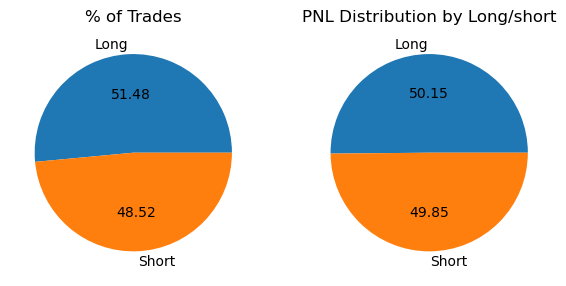

In [414]:
TradesbyType = pd.DataFrame(sortedPNL.groupby("L/S")["PNL"].count())
TradesbyType

fig , ax = plt.subplots(1,2, figsize = (7,5))
ax[0].set(title = "% of Trades")
ax[0].pie(x = TradesbyType["PNL"] , labels = TradesbyType.index ,  autopct='%.2f')

ax[1].set(title = "PNL Distribution by Long/short")
ax[1].pie(x = PNLbyType["PNL"] , labels = PNLbyType.index ,  autopct='%.2f')

plt.show()


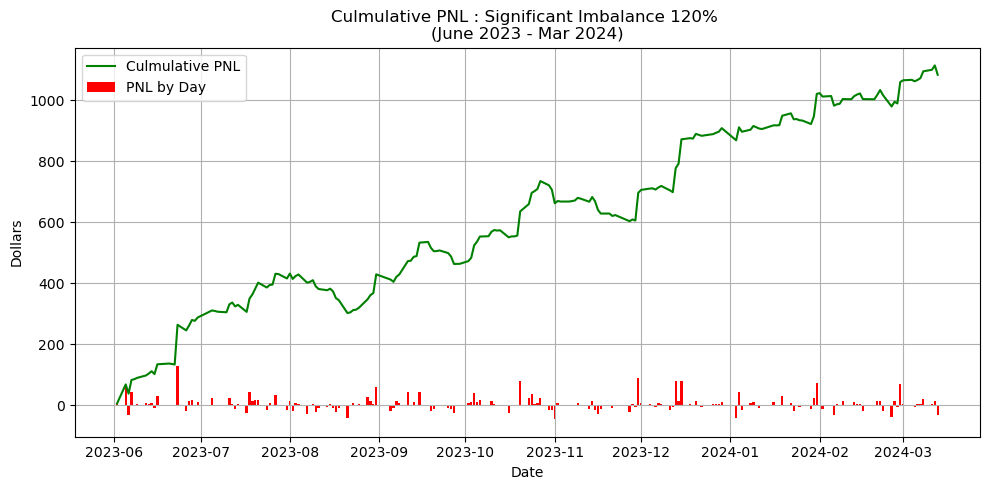

In [386]:
PNLbyDate = pd.DataFrame(sortedPNL.groupby("Date")["PNL"].sum())
PNLbyDate["Date"] = PNLbyDate.index
PNLbyDate["Culmulative PNL"] = PNLbyDate['PNL'].cumsum()

#PNLbyDate.reset_index(inplace = True)


fig , ax = plt.subplots(figsize = (10,5))
ax.set(title = "Culmulative PNL : Significant Imbalance 120% \n(June 2023 - Mar 2024)", xlabel = "Date" , ylabel = "Dollars")
ax.plot(PNLbyDate["Date"] , PNLbyDate["Culmulative PNL"], color = "green", label = "Culmulative PNL" )
ax.bar(PNLbyDate["Date"] , PNLbyDate["PNL"], color = "red",label = "PNL by Day")
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [470]:
def getImbalancePivotPNL3PM(imbData,ticker , sigPercent, startdate, enddate): 
    merged_df = getDFready(imbData , ticker, startdate, enddate)
    merged_df
    
    pos = 1000
    start_time = time(14, 30)  # 2:00 PM
    end_time = time(16, 0)    # 4:00 PM
    
    between_2_and_4 = merged_df[
        merged_df['Datetime_5min'].dt.time.between(start_time, end_time)
    ]
    
    dailys = merged_df.groupby('Date_x').agg(
            High=('High', 'max'),
            Low=('Low', 'min'),
            Close = ('Close' , 'last')
        )
    dailys.index = pd.to_datetime(dailys.index).date
    
    #print(dailys)
    seen_dates = set()
    TotalPNL = 0
    correctTrades = 0
    totalTrades = 0
    
    for _, row in between_2_and_4.iterrows():
        PNL = 0 
        dt = row['Datetime']
        price = row['Close']
        i = row["Pct_of_10DayMax_Imb"]
        highP = row["UpperBand"]
        lowP = row["LowerBand"]
        date_key = dt.date()
        if dt.time() == start_time and date_key in seen_dates:
            continue  # skip duplicates
    
        seen_dates.add(date_key)
    
        
            
        close = dailys.loc[date_key, "Close"]
        #print(close)
    
        
        if price > highP and dt.time() == start_time and i > sigPercent:
            PNL = (((close - price) / price)  *  pos )
            totalTrades +=1

            #print("Bull at 2pm", dt.time() , price , highP , i , dt.date(), "PNL: $" , PNL)
            
    
            
        elif price < lowP and dt.time() == start_time and i < -sigPercent:
            PNL =  -1 * (((close - price) / price)  *  pos )
            totalTrades +=1

            #print("Bear at 2pm" , dt.time() , price , lowP , i , dt.date(),  "PNL: $" , PNL)
        TotalPNL += PNL
    
        if PNL > 0 :
            correctTrades += 1
        
    
    
    
    return TotalPNL , correctTrades , totalTrades 



In [412]:
# at 3pm : $ 300.85327290320265, 50.543759709994816%,  1931 Trades
# at 3:30pm : $ 283.23865892825296 45.264116575591984% 2196 Trades
# at 3:50pm : $ 0.0 0.0 1203
# at 2:30pm : $ 781.3633767111104 53.696708041014574 1853



grandPNl = 0
PNLsList = []
grandCorrectTrades = 0 
grandTotalTrades = 0
for tick in tickersWithFilesComp:
    #print(tick)
    incP , incCT , incTT = getImbalancePivotPNL3PM(imbDataComprehensive, tick , 120 , "2023-06-02" , "2024-04-01")
    grandPNl += incP
    grandCorrectTrades += incCT
    grandTotalTrades += incTT
    PNLsList.append(incP)
percentCorrect = (grandCorrectTrades / grandTotalTrades) * 100
print("$" , grandPNl , percentCorrect , grandTotalTrades)

$ 781.3633767111104 53.696708041014574 1853


In [ ]:
# NOTES FOR MONDAY : 
# 1) Get rid of Index rebalance days : https://www.nyse.com/publicdocs/ICE_NYSE_2024_Yearly_Trading_Calendar.pdf

# 2) Look with trades with spy against with dollar amount against (add in market neutral) 

# 3) test 2:30 , 2:45, 3:00pm , 3:15pm, 3:30pm. 

# 4) imbalance > $2m , top 5 and 10 imbalances (do both)



In [1253]:
import yfinance as yf
SPY = yf.Ticker("SPY")
SPYPrice = SPY.history(period = '2y' , interval = "1h", start =  "2023-06-02", end = "2024-04-01")
SPYPrice["Symbol"] = "SPY"
SPYPrice.index = SPYPrice.index.tz_convert(None)

SPYPrice["Date+Time"] = pd.to_datetime(SPYPrice.index)
SPYPrice["Time"] = SPYPrice["Date+Time"].dt.time
SPYPrice["Date"] = SPYPrice["Date+Time"].dt.date


#SPYPrice = SPYPrice[SPYPrice['Time'].dt.time.between(time(14,0), time(16,0))]

SPYPrice = SPYPrice[["Symbol","Open", "Close" , "Date+Time" ,  "Open" , "High", "Low","Date", "Time"]]

 
#SPYPrice = SPYPrice[SPYPrice["Date+Time"].dt.time.between(time(14, 0), time(16, 0))]
SPYPrice
 


,Symbol,Open,Close,Date+Time,Open,High,Low,Date,Time
Datetime,,,,,,,,,
2023-06-02 13:30:00,SPY,424.500000,425.510010,2023-06-02 13:30:00,424.500000,426.375000,423.950012,2023-06-02,13:30:00
2023-06-02 14:30:00,SPY,425.510010,427.545013,2023-06-02 14:30:00,425.510010,427.690002,425.140015,2023-06-02,14:30:00
2023-06-02 15:30:00,SPY,427.559998,427.446503,2023-06-02 15:30:00,427.559998,427.690002,426.760010,2023-06-02,15:30:00
2023-06-02 16:30:00,SPY,427.440002,428.260010,2023-06-02 16:30:00,427.440002,428.385010,427.290009,2023-06-02,16:30:00
2023-06-02 17:30:00,SPY,428.269989,427.922394,2023-06-02 17:30:00,428.269989,428.339996,427.470001,2023-06-02,17:30:00
...,...,...,...,...,...,...,...,...,...
2024-03-28 15:30:00,SPY,523.579895,523.469971,2024-03-28 15:30:00,523.579895,523.729980,523.140015,2024-03-28,15:30:00
2024-03-28 16:30:00,SPY,523.469971,523.125000,2024-03-28 16:30:00,523.469971,523.489990,522.979980,2024-03-28,16:30:00
2024-03-28 17:30:00,SPY,523.125000,523.520020,2024-03-28 17:30:00,523.125000,523.645020,522.919983,2024-03-28,17:30:00


In [1255]:
SPY = yf.Ticker("SPY")
SPYDailyPrice = SPY.history(period = '2y' , interval = "1d")
SPYDailyPrice["Symbol"] = "SPY"
SPYDailyPrice["Daily Close"] = SPYDailyPrice["Close"] 
SPYDailyPrice.index = SPYDailyPrice.index.tz_convert(None)
SPYDailyPrice.index = SPYDailyPrice.index.date

   
#SPYDailyPrice = SPYDailyPrice.reset_index(drop=True)
SPYDailyPrice = SPYDailyPrice[["Daily Close"]]
SPYDailyPrice

,Daily Close
2023-05-31,406.709045
2023-06-01,410.573212
2023-06-02,416.510559
2023-06-05,415.712372
2023-06-06,416.617645
...,...
2025-05-23,579.109985
2025-05-27,591.150024
2025-05-28,587.729980
2025-05-29,590.049988


In [1257]:
dailyCloseList = []
SPYPrice.reset_index(drop=True, inplace=True)

for date in SPYPrice["Date"].unique():
    SPYPriceDF = SPYPrice[SPYPrice["Date"] == date]
    dailyClose = SPYDailyPrice.loc[date, "Daily Close"]
    for x in SPYPriceDF["Close"]:
        dailyCloseList.append(dailyClose)
    
SPYPrice["Daily Close"] = dailyCloseList

SPYPrice

,Symbol,Open,Close,Date+Time,Open,High,Low,Date,Time,Daily Close
0,SPY,424.500000,425.510010,2023-06-02 13:30:00,424.500000,426.375000,423.950012,2023-06-02,13:30:00,416.510559
1,SPY,425.510010,427.545013,2023-06-02 14:30:00,425.510010,427.690002,425.140015,2023-06-02,14:30:00,416.510559
2,SPY,427.559998,427.446503,2023-06-02 15:30:00,427.559998,427.690002,426.760010,2023-06-02,15:30:00,416.510559
3,SPY,427.440002,428.260010,2023-06-02 16:30:00,427.440002,428.385010,427.290009,2023-06-02,16:30:00,416.510559
4,SPY,428.269989,427.922394,2023-06-02 17:30:00,428.269989,428.339996,427.470001,2023-06-02,17:30:00,416.510559
...,...,...,...,...,...,...,...,...,...,...
1436,SPY,523.579895,523.469971,2024-03-28 15:30:00,523.579895,523.729980,523.140015,2024-03-28,15:30:00,516.496338
1437,SPY,523.469971,523.125000,2024-03-28 16:30:00,523.469971,523.489990,522.979980,2024-03-28,16:30:00,516.496338
1438,SPY,523.125000,523.520020,2024-03-28 17:30:00,523.125000,523.645020,522.919983,2024-03-28,17:30:00,516.496338
1439,SPY,523.525024,524.458008,2024-03-28 18:30:00,523.525024,524.580017,523.020020,2024-03-28,18:30:00,516.496338


In [1275]:
SPYPrice[800:850]

,Symbol,Open,Close,Date+Time,Open,High,Low,Date,Time,Daily Close
800,SPY,449.869995,448.730011,2023-11-14 20:30:00,449.869995,449.940002,448.290009,2023-11-14,20:30:00,439.934479
801,SPY,450.109985,450.700012,2023-11-15 14:30:00,450.109985,451.239990,449.399994,2023-11-15,14:30:00,440.865845
802,SPY,450.700012,450.799988,2023-11-15 15:30:00,450.700012,451.380005,450.470001,2023-11-15,15:30:00,440.865845
803,SPY,450.799988,450.169891,2023-11-15 16:30:00,450.799988,450.815002,449.540009,2023-11-15,16:30:00,440.865845
804,SPY,450.160004,449.739014,2023-11-15 17:30:00,450.160004,450.369995,448.799988,2023-11-15,17:30:00,440.865845
805,SPY,449.734985,450.440002,2023-11-15 18:30:00,449.734985,450.475006,449.592194,2023-11-15,18:30:00,440.865845
806,SPY,450.440002,450.070007,2023-11-15 19:30:00,450.440002,450.690002,449.744995,2023-11-15,19:30:00,440.865845
807,SPY,450.079987,449.640015,2023-11-15 20:30:00,450.079987,450.369995,449.209991,2023-11-15,20:30:00,440.865845
808,SPY,449.220001,449.950012,2023-11-16 14:30:00,449.220001,450.559998,449.130005,2023-11-16,14:30:00,441.405060
809,SPY,449.950012,448.329987,2023-11-16 15:30:00,449.950012,450.304993,448.279999,2023-11-16,15:30:00,441.405060


In [1167]:
import datetime as dt
def getpriceData(ticker):
    csvfile = str(ticker) + ".csv"
    df = pd.read_csv(csvfile)
    columns = [
    "Symbol", "Date", "Time", "Open", "High", "Low", "Close", "x1", "x2"
    ]
    
    # Save first row
    first_row = df.iloc[0]
    
    # Drop it from the top
    df = df.drop(index=0).reset_index(drop=True)
    
    # Set proper column names
    df.columns = columns
    
    # Optionally, append first row back if it's actual data
    # (convert first_row to match the new column names)
    first_row_df = pd.DataFrame([first_row.values], columns=columns)
    df = pd.concat([first_row_df, df], ignore_index=True)
    
    
    #priceData.drop(labels=["Unnamed: 9", "Unnamed: 10" , "Unnamed: 11"], inplace=True)[source]
    priceData = df.dropna(axis=1)
    priceData = priceData.rename(columns={'high': 'High'})
    
    
    
    priceData['Time'] = priceData['Time'].astype(str).str.zfill(4)
    priceData['Datetime'] = pd.to_datetime(priceData['Date'] + ' ' + priceData['Time'].str[:2] + ':' + priceData['Time'].str[2:])
    
    priceData['Time'] = priceData['Datetime'].dt.time
    priceData['Date'] =  priceData['Datetime'].dt.date
    #priceData.Date = priceData.Date.apply(pd.to_datetime, format='%y/%m/%d')

    #priceData = sortTime(priceData , startdate , enddate)
    priceData['Datetime_5min'] = priceData['Datetime'].dt.round('5min')
    
    
    
    #print(priceData[['Date', 'Time', 'Datetime']].head())
    
     
    
    pD = priceData
    pD = compute_open_range(priceData)
    pD = compute_pivot_range(pD)
    
    return pD




def DailyTopImbalances(imbData, date ,num,  sigPercentValue, sigDollarValue):
    
    imbData["Imbalance Dollars"] = imbData["Imbalance"] * imbData["LastSale"]
    imbData['SaleTime'] = pd.to_datetime(imbData['SaleTime'])
    imbData['SaleTime_5min'] = imbData['SaleTime'].dt.round('5min')
    
    imbData["Time"] = imbData["SaleTime_5min"].dt.time
    imbData["Date"] = imbData["SaleTime_5min"].dt.date
    
    imbData = imbData[["Symbol","Date", "Time","Imbalance Dollars", "Pct_of_10DayMax_Imb" ,"Flip" , "SaleTime_5min", "B/S"]]

   # print(imbData)
    
    
    
    
    # CONDITIONS
    #num = 5
    start_time = time(14, 0)  # 2:00 PM
    end_time = time(16, 0)  # 4:00 PM
    #sigPercentvalue = 120
    #sigDollarValue = 2000000
    
    #print(imbData)
    imbData.loc[:, "Date"] = pd.to_datetime(imbData["Date"]).dt.date
    sortedIMB = imbData[imbData["Date"] == pd.to_datetime(date).date()]

    #sortedIMB = imbData[imbData["Date"] == "2024-03-13"]
    #print(sortedIMB)
    condition1 = (sortedIMB["Imbalance Dollars"] > sigDollarValue)
    sortedIMB = sortedIMB[condition1]
    
    condition2 = (sortedIMB["Pct_of_10DayMax_Imb"].abs() > sigPercentvalue)
    
    sortedIMB = sortedIMB[condition2]
    
    sortedIMB = sortedIMB[
        sortedIMB["SaleTime_5min"].dt.time.between(start_time, end_time)
    ]
    
    
    
    
    timeCondition = (sortedIMB["Time"] == start_time)
    sortedIMB = sortedIMB[timeCondition]
    sortedIMB.sort_values(by = "Pct_of_10DayMax_Imb", inplace = True, ascending = False)
    
    buyIMB = sortedIMB[sortedIMB["B/S"] == "Buy"]
    sellIMB = sortedIMB[sortedIMB["B/S"] == "Sell"]
    
    top_num = buyIMB.nlargest(num, "Pct_of_10DayMax_Imb")
    bottom_num = sellIMB.nsmallest(num, "Pct_of_10DayMax_Imb")
    bottom_num.sort_values(by = "Pct_of_10DayMax_Imb" , inplace = True, ascending = False)
    concatList = [top_num , bottom_num]
    
    newDF = pd.concat(concatList)
    
    return newDF
    



In [797]:
imbDataComprehensive["Pct_of_10DayMax_Imb"] = imbDataComprehensive["Pct_of_10DayMax_Imb"].astype(int)


In [1099]:
indpriceData = getpriceData("HSY")
indpriceData

,Symbol,Date,Time,Open,High,Low,Close,x1,x2,Datetime,Datetime_5min,OP High,OP Low,Pivot,UpperBand,LowerBand
Datetime,,,,,,,,,,,,,,,,
2022-12-01 09:45:00,HSY,12/1/2022,09:45:00,233.71,235.09,233.71,234.72,5282,1624,2022-12-01 09:45:00,2022-12-01 09:45:00,235.09,233.71,188.990000,189.160000,188.82
2022-12-01 09:50:00,HSY,12/1/2022,09:50:00,234.80,235.17,234.75,235.09,2938,3217,2022-12-01 09:50:00,2022-12-01 09:50:00,235.09,233.71,188.990000,189.160000,188.82
2022-12-01 09:55:00,HSY,12/1/2022,09:55:00,235.19,235.67,234.90,234.90,1599,2407,2022-12-01 09:55:00,2022-12-01 09:55:00,235.09,233.71,188.990000,189.160000,188.82
2022-12-01 10:00:00,HSY,12/1/2022,10:00:00,234.89,234.90,234.55,234.65,1947,3646,2022-12-01 10:00:00,2022-12-01 10:00:00,235.09,233.71,188.990000,189.160000,188.82
2022-12-01 10:05:00,HSY,12/1/2022,10:05:00,234.81,235.01,233.62,233.62,800,1700,2022-12-01 10:05:00,2022-12-01 10:05:00,235.09,233.71,188.990000,189.160000,188.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-14 15:40:00,HSY,5/14/2024,15:40:00,209.06,209.06,208.68,208.69,8395,8518,2024-05-14 15:40:00,2024-05-14 15:40:00,210.93,210.00,208.453333,208.976667,207.93
2024-05-14 15:45:00,HSY,5/14/2024,15:45:00,208.72,208.85,208.58,208.83,6725,10130,2024-05-14 15:45:00,2024-05-14 15:45:00,210.93,210.00,208.453333,208.976667,207.93
2024-05-14 15:50:00,HSY,5/14/2024,15:50:00,208.86,208.87,208.53,208.57,15590,13542,2024-05-14 15:50:00,2024-05-14 15:50:00,210.93,210.00,208.453333,208.976667,207.93


In [1135]:
def getSPYPosition(usableDF):
    countsDF = pd.DataFrame(usableDF.groupby("B/S")["Symbol"].count())
    numberBuys = countsDF.loc["Buy", "Symbol"]
    numberSells = countsDF.loc["Sell", "Symbol"]
    
    SPYPOS = {"Amount" : 0 , "Pos" : ""}
    if numberBuys > numberSells:
        SPYPOS["Amount"] = (numberBuys - numberSells)
        SPYPOS["Pos"] = "Short"
    elif numberBuys < numberSells:
        SPYPOS["Amount"] = (numberSells - numberBuys)
        SPYPOS["Pos"] = "Long"
    
    return SPYPOS

In [1179]:
imbData = pd.read_csv("CleanedimbalanceData.csv")
date = "2024-02-16"

totalImbalanceData = imbDataComprehensive[imbDataComprehensive["Symbol"].isin(tickersWithFilesComp)].copy()

usableDF = DailyTopImbalances(totalImbalanceData ,date ,  5, 120 , 2000000)

#tickersWithFilesComp

def getusableImbalanceDataWithPriceByDate(usableDF , date):
    twopmPrices = []
    dailyClose = []
    lb = []
    hb = []
    for tick in usableDF["Symbol"]:
        start_time = time(14, 00)  # 2:00 PM
        end_time = time(16, 0)    # 4:00 PM
        indpriceData = getpriceData(tick)
        indpriceData.loc[:, "Date"] = pd.to_datetime(indpriceData["Date"]).dt.date
        indpriceData =  indpriceData[indpriceData["Date"] == pd.to_datetime(date).date()]
        sortedPriceData =  indpriceData[indpriceData['Datetime_5min'].dt.time.between(start_time, end_time)]
        #sortedPriceData = sortedPriceData[sortedPriceData["Date"] == date]
      #  print(sortedPriceData)
        dailyPrices = pd.DataFrame(sortedPriceData.groupby("Date").agg(
                High=('High', 'max'),
                Low=('Low', 'min'),
                Open = ('Open' , 'first'),
                Close = ('Close', 'last'),
                HB = ('UpperBand','first'),
                LB = ('LowerBand','first')
            ))
       # print(sortedPriceData)
        #print(dailyPrices)
        twopmPrices.append(dailyPrices.iloc[0,2])
        dailyClose.append(dailyPrices.iloc[0,3])
        hb.append(dailyPrices.iloc[0,4])
        lb.append(dailyPrices.iloc[0,5])
        
    
    
    usableDF["Range open price"] = twopmPrices
    usableDF["Range close price"] = dailyClose
    usableDF["Upper Pivot Band"] = hb
    usableDF["Lower Pivot Band"] = lb
 
    
    return usableDF

priceImbalanceDF = getusableImbalanceDataWithPriceByDate(usableDF, "2024-02-16")
priceImbalanceDF


,Symbol,Date,Time,Imbalance Dollars,Pct_of_10DayMax_Imb,Flip,SaleTime_5min,B/S,Range open price,Range close price,Upper Pivot Band,Lower Pivot Band
27969,BDX,2024-02-16,14:00:00,18254250.0,441,Same,2024-02-16 14:00:00,Buy,243.40,240.76,240.390000,240.103333
78230,DUK,2024-02-16,14:00:00,24833250.0,290,Same,2024-02-16 14:00:00,Buy,91.96,91.88,92.063333,91.470000
76203,DPZ,2024-02-16,14:00:00,8528600.0,250,Same,2024-02-16 14:00:00,Buy,425.69,421.97,425.375000,425.038333
8440,AJG,2024-02-16,14:00:00,22187640.0,158,Same,2024-02-16 14:00:00,Buy,241.07,239.17,240.443333,240.050000
102097,GE,2024-02-16,14:00:00,7038720.0,151,Same,2024-02-16 14:00:00,Buy,119.47,118.97,118.188333,117.905000
71671,DHI,2024-02-16,14:00:00,6285400.0,-133,Same,2024-02-16 14:00:00,Sell,142.73,141.26,145.450000,145.396667
54640,CMI,2024-02-16,14:00:00,8859180.0,-143,Same,2024-02-16 14:00:00,Sell,268.50,266.48,265.055000,263.585000
24672,BAC,2024-02-16,14:00:00,32678400.0,-164,Same,2024-02-16 14:00:00,Sell,34.00,34.09,33.966667,33.780000
62558,CTRA,2024-02-16,14:00:00,6079675.0,-207,Same,2024-02-16 14:00:00,Sell,24.82,24.68,24.566667,24.380000
171976,NCLH,2024-02-16,14:00:00,3189225.0,-443,Same,2024-02-16 14:00:00,Sell,16.35,16.24,16.730000,16.590000


In [1401]:

def PNLbyDate(date , priceImbalanceDF , SPYPrice , numPos, wantedData):

    posSize = 100000
    totalPNL = 0
    numBuys = 0
    numSells = 0
    PNL = 0
    dates = []
    size = []
    types = []
    PNLS = []
    symbols = []
    for _, row in priceImbalanceDF.iterrows(): #BUYS
            symbol = row['Symbol']
            dt = row['Date']
            price = row['Range open price']
            i = row["Pct_of_10DayMax_Imb"]
            highP = row["Upper Pivot Band"]
            close = row["Range close price"]
            lowP = row["Lower Pivot Band"]
            PosType = row["B/S"]
            #date_key = dt.date()
        
            #if dt.time() == start_time and date_key in seen_dates:
               # continue  # skip duplicates
                
            if price > highP and PosType == "Buy" and numBuys < (numPos):
                rPercent = ((close - price) / price)
                PNL += posSize * rPercent
                numBuys += 1
                dates.append(date)
                symbols.append(symbol)
                size.append(posSize)
                types.append(PosType)
                PNLS.append(posSize * rPercent)
            if numBuys == (numPos):
                break
            
    lowpriceImbalanceDF = priceImbalanceDF.sort_values(by = "Pct_of_10DayMax_Imb" , ascending = True).copy()     
    for _, row in lowpriceImbalanceDF.iterrows(): #BUYS
        dt = row['Date']
        price = row['Range open price']
        i = row["Pct_of_10DayMax_Imb"]
        highP = row["Upper Pivot Band"]
        close = row["Range close price"]
        lowP = row["Lower Pivot Band"]
        PosType = row["B/S"]
         
        if price < lowP and PosType == "Sell" and numSells < (numPos /2):
            rPercent = -1 * ((close - price) / price)
            PNL += posSize * rPercent
            numSells +=1
            dates.append(date)
            symbols.append(symbol)
            size.append(posSize)
            types.append(PosType)
            PNLS.append(posSize * rPercent)
            
        if numSells == (numPos):
            break
                
    
            # SETTING UP THE SPY POSITION:
    SPYDF = SPYPrice[ SPYPrice["Date"] == date].copy()
    if numBuys > numSells: #GETTING SHORT SPY
       numShortPos = numBuys - numSells

       SPYClose =  SPYDF["Daily Close"].mean()
       SPYIDPrice = SPYDF["Low"].iloc[0]
       SPYReturn = -1 * ((SPYClose - SPYIDPrice) / (SPYIDPrice))
       PNL += SPYReturn * posSize * numShortPos
       numSells += numShortPos
       dates.append(date)
       symbols.append("SPY")
       size.append(posSize * numShortPos)
       types.append("Sell")
       PNLS.append(SPYReturn * posSize * numShortPos)
        
    elif numBuys < numSells: # GETTING LONG
       numLongPos = numSells - numBuys
       SPYClose =  SPYDF["Daily Close"].mean()
       SPYIDPrice = SPYDF["High"].iloc[0]
       SPYReturn =  ((SPYClose - SPYIDPrice) / (SPYIDPrice))
       PNL += SPYReturn * posSize * numLongPos
       numBuys += numLongPos
       dates.append(date)
       symbols.append("SPY")
       size.append(posSize * numLongPos)
       types.append("Buy")
       PNLS.append(SPYReturn * posSize * numLongPos)
        
    else: # Already market neutral
        PNL += 0

    dictPNL = {"Date": dates, "Symbol" : symbols ,"PNL" : PNLS , "L/S" : types, "Size ($)" : size}
    dfPNL = pd.DataFrame(dictPNL)
    
    if wantedData == "DataFrame":          
        return dfPNL
    else:
        return PNL

            
        
            

In [1323]:
totalImbalanceData = imbDataComprehensive[imbDataComprehensive["Symbol"].isin(tickersWithFilesComp)].copy()
totalImbalanceData.sort_values(by = "SaleTime_5min", ascending = True, inplace = True)
totalPNL = 0
dfList = []
for date in totalImbalanceData["Date"].unique():
    print(date)
    usableDF = DailyTopImbalances(totalImbalanceData ,date ,  20 , 120 , 2000000)
    priceImbalanceDF = getusableImbalanceDataWithPriceByDate(usableDF, date)
    incDF = PNLbyDate(date, priceImbalanceDF, SPYPrice, 5, "DataFrame")
    dfList.append(incDF)


dictsCompPNL = pd.concat(dfList)

dictsCompPNL


2023-06-02
2023-06-05
2023-06-06
2023-06-07
2023-06-08
2023-06-09
2023-06-12
2023-06-13
2023-06-14
2023-06-15
2023-06-16
2023-06-20
2023-06-21
2023-06-22
2023-06-23
2023-06-26
2023-06-27
2023-06-28
2023-06-29
2023-06-30
2023-07-03
2023-07-05
2023-07-06
2023-07-07
2023-07-10
2023-07-11
2023-07-12
2023-07-13
2023-07-14
2023-07-17
2023-07-18
2023-07-19
2023-07-20
2023-07-21
2023-07-24
2023-07-25
2023-07-26
2023-07-27
2023-07-28
2023-07-31
2023-08-01
2023-08-02
2023-08-03
2023-08-04
2023-08-07
2023-08-08
2023-08-09
2023-08-10
2023-08-11
2023-08-14
2023-08-15
2023-08-16
2023-08-17
2023-08-18
2023-08-21
2023-08-22
2023-08-23
2023-08-24
2023-08-25
2023-08-28
2023-08-29
2023-08-30
2023-08-31
2023-09-05
2023-09-06
2023-09-07
2023-09-08
2023-09-11
2023-09-12
2023-09-13
2023-09-14
2023-09-15
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-25
2023-09-26
2023-09-27
2023-09-28
2023-09-29
2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-09
2023-10-10
2023-10-11
2023-10-12

,Date,Symbol,PNL,L/S,Size ($)
0,2023-06-02,CHD,406.895813,Buy,100000.0
1,2023-06-02,GE,-776.196636,Buy,100000.0
2,2023-06-02,MA,-194.994257,Buy,100000.0
3,2023-06-02,BSX,562.669771,Buy,100000.0
4,2023-06-02,FMC,290.370925,Buy,100000.0
...,...,...,...,...,...
4,2024-03-13,FDX,-592.038638,Buy,100000.0
5,2024-03-13,FDX,-846.036029,Sell,100000.0
6,2024-03-13,FDX,901.302873,Sell,100000.0
7,2024-03-13,FDX,1184.095488,Sell,100000.0


In [1307]:
# Had to remove around 18% of equities present before starting due to a lack of price data. 
# Had to make a worst case scenario when using the entry price for SPY position due to not having granular data : instead of having by the hour I had every hour on the half hour (1:30, 2:30 etc)
# when getting short I used the low between 1:30 and 2:30 and the high when getting long


len(totalImbalanceData["Date"].unique())

194

In [1333]:
dictsCompPNL


,Date,Symbol,PNL,L/S,Size ($)
0,2023-06-02,CHD,406.895813,Buy,100000.0
1,2023-06-02,GE,-776.196636,Buy,100000.0
2,2023-06-02,MA,-194.994257,Buy,100000.0
3,2023-06-02,BSX,562.669771,Buy,100000.0
4,2023-06-02,FMC,290.370925,Buy,100000.0
...,...,...,...,...,...
4,2024-03-13,FDX,-592.038638,Buy,100000.0
5,2024-03-13,FDX,-846.036029,Sell,100000.0
6,2024-03-13,FDX,901.302873,Sell,100000.0
7,2024-03-13,FDX,1184.095488,Sell,100000.0


In [1381]:
PNLBYDATE = pd.DataFrame(dictsCompPNL.groupby("Date")["PNL"].sum())
PNLBYDATE["Culmulative PNL"] = PNLBYDATE["PNL"].cumsum()
PNLBYDATE

,PNL,Culmulative PNL
Date,,
2023-06-02,9062.720036,9062.720036
2023-06-05,3761.814301,12824.534337
2023-06-06,-5318.595880,7505.938457
2023-06-07,11677.114099,19183.052555
2023-06-08,-4106.212996,15076.839560
...,...,...
2024-03-07,972.958521,211382.400470
2024-03-08,1093.637468,212476.037938
2024-03-11,-383.082093,212092.955845


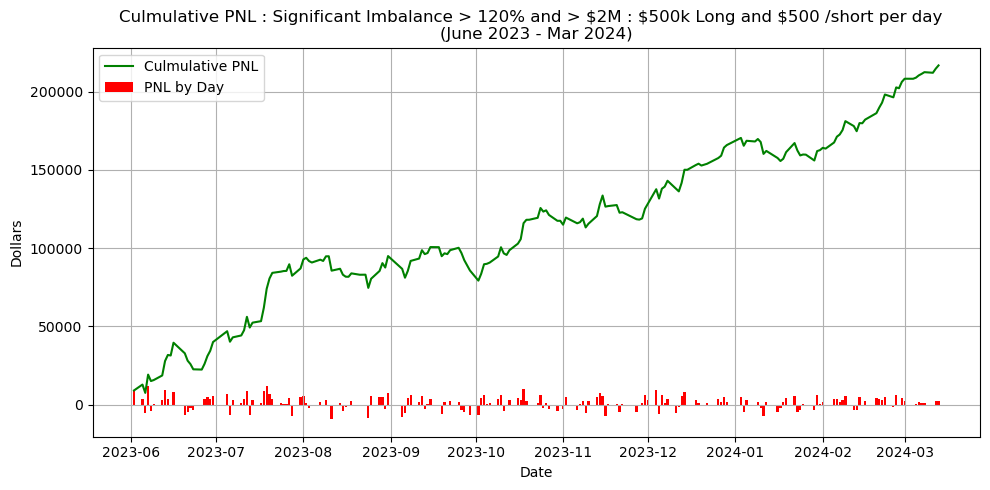

In [1379]:
fig , ax = plt.subplots(figsize = (10,5))
ax.set(title = "Culmulative PNL : Significant Imbalance > 120% and > $2M : $500k Long and $500 /short per day  \n(June 2023 - Mar 2024)", xlabel = "Date" , ylabel = "Dollars")
ax.plot(PNLBYDATE.index , PNLBYDATE["Culmulative PNL"], color = "green", label = "Culmulative PNL" )
ax.bar(PNLBYDATE.index , PNLBYDATE["PNL"], color = "red",label = "PNL by Day")
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [1385]:
# PNL from SPY
PNLBYSYMBOL = pd.DataFrame(dictsCompPNL.groupby("Symbol")["PNL"].sum())

PNLBYSYMBOL.loc["SPY" , "PNL"]



232643.34888923517

In [1375]:
# TRADES PER DAY 
TRADESPERDAY = pd.DataFrame(dictsCompPNL.groupby("Date")["Symbol"].count())
TRADESPERDAY["Symbol"].mean()

5.7407407407407405

In [1389]:
SPYONLY  = dictsCompPNL[dictsCompPNL["Symbol"] == "SPY"]
SPYONLY["Culmulative PNL"] = SPYONLY["PNL"].cumsum()
SPYONLY

/var/folders/88/8t48c89d66vgtlj2jjgmfbmh0000gn/T/ipykernel_70225/1208081030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPYONLY["Culmulative PNL"] = SPYONLY["PNL"].cumsum()


,Date,Symbol,PNL,L/S,Size ($),Culmulative PNL
5,2023-06-02,SPY,8773.974420,Sell,500000.0,8773.974420
8,2023-06-05,SPY,5573.805823,Sell,200000.0,14347.780243
4,2023-06-06,SPY,-5150.414842,Long,200000.0,9197.365402
7,2023-06-07,SPY,8960.834229,Sell,300000.0,18158.199631
4,2023-06-08,SPY,-4571.982498,Long,200000.0,13586.217132
...,...,...,...,...,...,...
3,2024-03-05,SPY,1742.777128,Sell,100000.0,226426.696141
3,2024-03-06,SPY,1305.097321,Sell,100000.0,227731.793463
3,2024-03-07,SPY,1057.133974,Sell,100000.0,228788.927437
8,2024-03-12,SPY,843.746602,Sell,200000.0,229632.674039


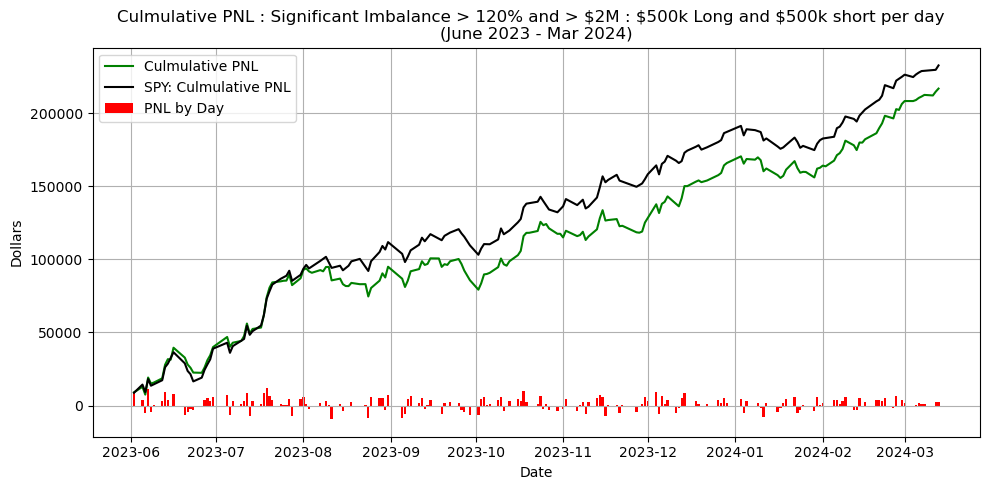

In [1397]:
fig , ax = plt.subplots(figsize = (10,5))
ax.set(title = "Culmulative PNL : Significant Imbalance > 120% and > $2M : $500k Long and $500k short per day  \n(June 2023 - Mar 2024)", xlabel = "Date" , ylabel = "Dollars")
ax.plot(PNLBYDATE.index , PNLBYDATE["Culmulative PNL"], color = "green", label = "Culmulative PNL" )
ax.plot(SPYONLY["Date"] , SPYONLY["Culmulative PNL"], color = "black", label = "SPY: Culmulative PNL" )
ax.bar(PNLBYDATE.index , PNLBYDATE["PNL"], color = "red",label = "PNL by Day")
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [1411]:
SPYBYTYPE = pd.DataFrame(SPYONLY.groupby("L/S")["PNL"].count())
SPYBYTYPE

,PNL
L/S,
Long,48
Sell,113


In [1425]:
totalImbalanceData = imbDataComprehensive[imbDataComprehensive["Symbol"].isin(tickersWithFilesComp)].copy()
def PNLImbalanceSimulation(totalImbalanceData, sigPercent, numTradesPerDay):
    totalImbalanceData.sort_values(by = "SaleTime_5min", ascending = True, inplace = True)
    totalPNL = 0
    dfList = []
    for date in totalImbalanceData["Date"].unique():
       # print(date)
        usableDF = DailyTopImbalances(totalImbalanceData ,date ,  20 , sigPercent , 2000000)
        priceImbalanceDF = getusableImbalanceDataWithPriceByDate(usableDF, date)
        PNL = PNLbyDate(date, priceImbalanceDF, SPYPrice, 5, "PNL")
        totalPNL += PNL
    
    
    return PNL



In [ ]:
import numpy as np
rows = np.arange(5,15, 1) 
columns = np.arange(100,200, 10)



sensitivityTable = pd.DataFrame(columns= columns, index= rows)


for r in rows:
    for c in columns:
        sensitivityTable.loc[r,c] = PNLImbalanceSimulation(totalImbalanceData,c, r)

sensitivityTable = sensitivityTable.astype(float)



def colorDF(df):
        # Color function: red if negative, green if positive
        def color_red_or_green(val):
            color = 'red' if val < 0 else 'green'
            return f'color: {color}'
        
        # Apply styling
        styled = (
        sensitivityTable.style
        .applymap(color_red_or_green)
        .set_properties(**{'background-color': 'white'})
        )
        
        # Show the styled table
        return styled
    
colorDF(sensitivityTable)